# **KF on existing predictions**

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

#%matplotlib notebook
#plt.rcParams['figure.figsize'] = 8, 8

import mpld3
mpld3.enable_notebook()
plt.rcParams['figure.figsize'] = 10,10

import json
import os
import math

%load_ext autoreload
%autoreload
import sys
sys.path.insert(0, "/home/usuario/project/src")

from kalmanfiltermotion import KalmanMotionTracker

#### Path setup

In [2]:
home_path = '/home/usuario/'

datasets_path = os.path.join(home_path, 'project_data', 'datasets')

all_datasets = ['KITTITrackletsCars', 'KITTITrackletsCarsPersons', 'KITTITrackletsCarsHard', 'KITTITrackletsCarsPersonsHard']

In [79]:
# This is the output from the NN
predictions = pd.read_csv(os.path.join(datasets_path, all_datasets[0], "NN_output.csv"))
# This gives information about the paths
eval_info = pd.read_csv(os.path.join(datasets_path, all_datasets[0], "info_eval.csv"))

In [4]:
def plot_route_df(route):
    """ Plots given route from DataFrame
        Show both the ground truth and the predicted
    """
    plt.plot(route['gt_pc1centers_x'], route['gt_pc1centers_y'], '-ok',color='black')
    plt.plot(route['gt_pc1centers_x']+route['pred_trans_x'], route['gt_pc1centers_y']+route['pred_trans_y'], '-ok', color='orange')

In [131]:
class Route:
    """ Class to contain all the route data 
        Params:
        - name: (string) Name of the track; Used to identify tracks in the list.
        - full: (bool) Flag to indicate if this route has got full measurements information
        or it only has metainfo.
        - generated: (DataFrame) Contains info generated from nn, kf or a combination of both.
        - ground_truth: (DataFrame) Contains ground truth for each timestamp.
        - routes: (DataFrame) Contains the position (x,y,a) per timepoint. Used for plotting or
        computing error.
        - error: (DataFrame) Contains the error computation per timepoint. It is agregated to compute
        the full track error.
        TBC.
    """
    
    def __init__(self, name, base_data):
        # Basic parameters
        self.name = name
        self.full = True
        
        # Support parameters
        n_timestamps = base_data.shape[0]
        df_index = np.arange(n_timestamps)
        
        # Remove the index for the dataframe
        base_data.reset_index(drop=True, inplace=True)
        
        # Create dataframe for each table
        # Generated information -> nn, kf, lstm
        self.generated = pd.DataFrame(0, index=df_index, columns=['nn_x', 'nn_y', 'nn_a'])
        self.generated[['nn_x', 'nn_y', 'nn_a']] = base_data[['pred_trans_x', 'pred_trans_y','pred_angles']]
        
        # Info from the meta files -> translation and pc1centers
        self.ground_truth = pd.DataFrame(0, index=df_index, columns=['x', 'y', 'a', 'pc1centers_x', 'pc1centers_y', 'pc1_a'])
        self.ground_truth[['x', 'y', 'a', 'pc1centers_x', 'pc1centers_y', 'pc1_a']] = base_data[['gt_trans_x', 'gt_trans_y', 'gt_angles', 'gt_pc1centers_x', 'gt_pc1centers_y', 'gt_pc1angles']]
        
        # Generated routes ex. -> pc1center+gt_trans, cumulative routes based on preds
        self.routes = pd.DataFrame(0, index=df_index, columns=['gt_x', 'gt_y', 'gt_a', 'nn_x', 'nn_y', 'nn_a'])
        
        # Computed errors for each prediciton
        self.error = pd.DataFrame(0, index=df_index, columns=[])
        
    def make_routes_base(self):
        pass
    
    def run_kalman_filter(self):
        pass
    
    def compute_error(self, cat):
        pass
    
    def plot_route(self):
        pass
        

#### Split into different route/tables

In [73]:
def routes_to_dict(eval_info, predictions):
    ''' Loads (meta)info from disk to memory classes for easy manipulation '''
    routes = dict()
    n_routes = eval_info.shape[0]
    for i in range(n_routes):
        current = eval_info.iloc[i]
        start_i = current['cumsum']
        end_i = start_i + current['n_points']
        current_pred = predictions.iloc[start_i:end_i]
        
        routes[current['name']] = current_pred
            
    return routes

In [74]:
# Angles correction Reduces the MSE from 200 to 66 degrees.
predictions.loc[predictions['pred_angles']>3, 'pred_angles'] = predictions[predictions['pred_angles']>3]['pred_angles'] - 3
predictions.loc[predictions['pred_angles']<-3, 'pred_angles'] = predictions[predictions['pred_angles']<-3]['pred_angles'] + 3

In [75]:
# plt.plot(predictions['pred_angles'])
# plt.plot(predictions['gt_angles'])

In [76]:
routes = routes_to_dict(eval_info, predictions)

In [104]:
a = pd.DataFrame(0,index=np.arange(3), columns=['col1', 'col2'])
b = np.array([[1,2],[3,4],[5,6]])

#### Plot single tables

In [10]:
i = 10

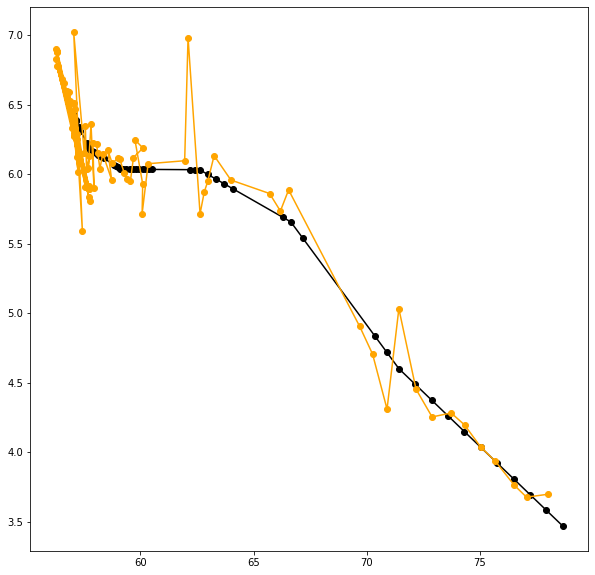

In [11]:
plot_route_df(routes[list(routes.keys())[i]])
i += 1

#### Run simple evaluation

In [12]:
def compute_error_route(route):    
    """ Computes the RMSE for translation and angle """
    # squared
    route.loc[:,'error_x'] = (route['pred_trans_x']-route['gt_trans_x'])**2
    route.loc[:,'error_y'] = (route['pred_trans_y']-route['gt_trans_y'])**2
    route.loc[:,'error_angle'] = ((route['pred_angles']-route['gt_angles'])*180)**2
    # mean
    x_e = np.mean(route['error_x'])
    y_e = np.mean(route['error_y'])
    a_e = np.mean(route['error_angle'])
    # root
    trans = (x_e+y_e)**0.5
    angle = a_e**0.5
    
    #print(f"RMSE Trans: {trans}\nRMSE Angle: {angle}")
    
    return trans, angle

In [13]:
def compute_error(eval_info, routes):
    """ Computer error over all routes
        Params:
        TBC
    """
    # Array declaration
    error = np.zeros((eval_info.shape[0],2))
    # For each route compute error and store it to array
    for i, route in enumerate(routes.values()):
        trans, angle = compute_error_route(route)
        error[i,:] = [trans, angle]
    
    # Pass info from np.arrays to dataframe
    eval_info['error_trans'], eval_info['error_angle'] = error[:,0], error[:,1]
    # Remember that -2 in the routes index? The first route had 0 points so
    # it is a NaN. TODO: Investigate this
    #eval_info = eval_info.drop([0], axis=0)
    
    trans_error = np.mean(eval_info['error_trans'])
    angle_error = np.mean(eval_info['error_angle'])
    
    print(f"RMSE trans: {trans_error}\nRMSE angle: {angle_error}")
    
    return trans_error, angle_error

In [14]:
def compute_error_kf(eval_info, routes):
    """ Computer error over all routes
        Params:
        TBC
    """
    # Array declaration
    error = np.zeros((eval_info.shape[0],2))
    # For each route compute error and store it to array
    for i, route in enumerate(routes.values()):
        # This is bc there are some routes without the kf columns
        if route.shape[0] == 0:
            error[i,:] = [np.nan, np.nan]
        else:
            trans, angle = compute_error_route_kf(route)
            error[i,:] = [trans, angle]
    
    # Pass info from np.arrays to dataframe
    eval_info['kf_error_trans'], eval_info['kf_error_angle'] = error[:,0], error[:,1]
    
    
    trans_error = np.mean(eval_info['kf_error_trans'])
    angle_error = np.mean(eval_info['kf_error_angle'])
    
    print(f"RMSE kf trans: {trans_error}\nRMSE kf angle: {angle_error}")
    
    return trans_error, angle_error

In [15]:
compute_error(eval_info, routes)

/home/usuario/.conda/envs/thesis/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/usuario/.conda/envs/thesis/lib/python3.7/site-packages/pandas/core/indexing.py:1046: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


RMSE trans: 0.17773658056018654
RMSE angle: 133.3402546803101


(0.17773658056018654, 133.3402546803101)

#### Run KF on single table

In [59]:
def run_kf_predictions(route):
    """ Runs Kalman Filter on the predictions 
        Params:
        -
        -
    """
    # Tracker object initialization
    position = route.iloc[0,0:3].values
    tracker = KalmanMotionTracker(position)
    
    # Container for the KF data
    kf = np.zeros((route.shape[0],3))
    kf[0,:] = route.iloc[0,0:3]
    # We feed from 0 to N observations to the filter
    for i in range(1, route.shape[0]):
        position = route.iloc[i,0:3].values
        tracker.update(position)
        # We store the inmediate pose
        tracker.predict()
        predictions = tracker.get_state()
        kf[i,:] = predictions[:3]
        
    return kf

In [60]:
for i in range(len(routes)):
    
    route = routes[list(routes.keys())[i]]
    
    kf_pred = run_kf_predictions(route)
    
    route[['kf_trans_x','kf_trans_y', 'kf_angle']] = pd.DataFrame(kf_pred, index=route.index)

/home/usuario/.conda/envs/thesis/lib/python3.7/site-packages/pandas/core/frame.py:2960: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [61]:
route

,pred_trans_x,pred_trans_y,pred_angles,gt_trans_x,gt_trans_y,gt_angles,gt_pc1centers_x,gt_pc1centers_y,gt_pc1angles,error_x,error_y,error_angle,kf_trans_x,kf_trans_y,kf_angle
8773,-1.761873,0.130287,0.142058,-1.721062,0.088367,-0.000085,37.482900,5.949889,1.593846,1.665554e-03,0.001757,654.630057,-1.761873,0.130287,0.142058
8774,-1.739563,0.123880,0.144528,-1.721062,0.088368,-0.000086,35.761837,6.038256,1.593761,3.423166e-04,0.001261,677.587502,-1.720934,0.122653,0.143097
8775,-1.778359,0.108651,0.140598,-1.874142,0.058147,-0.000145,34.040775,6.126624,1.593675,9.174249e-03,0.002551,641.802564,-0.317686,0.115680,0.141853
8776,-1.885852,0.074609,0.131153,-1.874147,0.058148,-0.000146,32.166634,6.184771,1.593530,1.369860e-04,0.000271,558.560267,-0.986365,0.101989,0.138286
8777,-1.840217,0.069048,0.125707,-1.874144,0.058147,-0.000145,30.292486,6.242919,1.593384,1.151021e-03,0.000119,513.176168,-1.315224,0.093717,0.135127
8778,-1.852318,0.122227,0.136676,-1.874146,0.058148,-0.000145,28.418343,6.301066,1.593239,4.764441e-04,0.004106,606.525407,-1.513489,0.099476,0.135440
8779,-1.904972,0.067866,0.135173,-1.874144,0.058148,-0.000146,26.544197,6.359214,1.593094,9.503594e-04,0.000094,593.286815,0.346622,0.094120,0.135395
8780,-1.790832,0.077748,0.129071,-1.790123,0.064415,0.004936,24.670053,6.417362,1.592948,5.023974e-07,0.000178,499.262924,-0.423045,0.091724,0.134469
8781,-1.744223,0.035798,0.124146,-1.790121,0.064415,0.004937,22.879930,6.481777,1.597884,2.106672e-03,0.000819,460.426107,-0.897361,0.084499,0.133136
8782,-1.535548,0.055220,0.129425,-1.790121,0.064416,0.004936,21.089810,6.546192,1.602821,6.480736e-02,0.000085,502.121942,-1.126194,0.081104,0.132705


**Run KF evaluation**

In [62]:
def compute_error_route_kf(route):    
    """ Computes the RMSE for translation and angle """
    # squared
    #route.loc[:,'kf_error'] = (route['kf_trans_x']-route['gt_trans_x'])**2 + (route['kf_trans_y']-route['gt_trans_y'])**2
    route.loc[:,'kf_error_x'] = (route['kf_trans_x']-route['gt_trans_x'])**2
    route.loc[:,'kf_error_y'] = (route['kf_trans_y']-route['gt_trans_y'])**2
    route.loc[:,'kf_error_angle'] = ((route['kf_angle']-route['gt_angles'])*180)**2
    
    # mean
    #t_e = np.mean(route['kf_error'])
    x_e = np.mean(route['kf_error_x'])
    y_e = np.mean(route['kf_error_y'])
    a_e = np.mean(route['kf_error_angle'])
    # root
    trans = (x_e+y_e)**0.5
    #trans = t_e**0.5
    angle = a_e**0.5
    
    #print(f"RMSE Trans: {trans}\nRMSE Angle: {angle}")
    
    return trans, angle

In [63]:
def compute_error_kf(eval_info, routes):
    """ Computer error over all routes
        Params:
        TBC
    """
    # Array declaration
    error = np.zeros((eval_info.shape[0],2))
    # For each route compute error and store it to array
    for i, route in enumerate(routes.values()):
        # This is bc there are some routes without the kf columns
        if route.shape[0] == 0:
            error[i,:] = [np.nan, np.nan]
        else:
            trans, angle = compute_error_route_kf(route)
            error[i,:] = [trans, angle]
    
    # Pass info from np.arrays to dataframe
    eval_info['kf_error_trans'], eval_info['kf_error_angle'] = error[:,0], error[:,1]
    
    
    trans_error = np.mean(eval_info['kf_error_trans'])
    angle_error = np.mean(eval_info['kf_error_angle'])
    
    print(f"RMSE kf trans: {trans_error}\nRMSE kf angle: {angle_error}")
    
    return trans_error, angle_error

In [64]:
compute_error_kf(eval_info, routes)

RMSE kf trans: 0.939367958660691
RMSE kf angle: 50.30595459101367


(0.939367958660691, 50.30595459101367)

**Visualize results**

In [65]:
def create_arrow(posx, posy, angle, color, norm):
    return patches.FancyArrow(posx, posy, norm*math.cos(angle), norm*math.sin(angle), width=0.01, head_width=0.05, head_length=0.06, color=color)

In [70]:
def plot_route_df_kf(name, routes, eval_info, arrows=True):
    """ Plots given route from DataFrame
        Show both the ground truth and the predicted
    """
    route = routes[name]
    route_info = eval_info.loc[eval_info['name'] == name]
    nn_rmse = route_info['error_trans'].values[0]
    kf_rmse = route_info['kf_error_trans'].values[0]
    
    mean_dist = (abs(np.mean(route['gt_trans_x']))**2+np.mean(route['gt_trans_y'])**2)**0.5
    print(mean_dist)
    
    fig, ax = plt.subplots()
    
    # Add the position data points
    gt_p = [route['gt_pc1centers_x'], route['gt_pc1centers_y']]
    pc_p = [gt_p[0]+route['gt_trans_x'],gt_p[1]+route['gt_trans_y']]
    pr_p = [gt_p[0]+route['pred_trans_x'], gt_p[1]+route['pred_trans_y']]
    kf_p = [gt_p[0]+route['kf_trans_x'], gt_p[1]+route['kf_trans_y']]
    pe_p = [route['route_pred_x'], route['route_pred_y']]
    
    # Add the angle data points
    gt_a = route['gt_pc1angles']
    pc_a = gt_a+route['gt_angles']
    pr_a = gt_a+route['pred_angles']
    kf_a = gt_a+route['kf_angle']
    
    
    ax.plot(pc_p[0], pc_p[1], '-ok', color='black')
    ax.plot(pr_p[0], pr_p[1], '-ok', color='orange')
    ax.plot(kf_p[0], kf_p[1], '-ok', color='red')
    ax.plot(pe_p[0], pe_p[1], '-ok', color='blue')
    
    if arrows:
        # Add the arrows
        for posx, posy, ang in zip(pc_p[0], pc_p[1], pc_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'black', mean_dist/7))
        for posx, posy, ang in zip(pr_p[0], pr_p[1], pr_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'orange', mean_dist/7))
        for posx, posy, ang in zip(kf_p[0], kf_p[1], kf_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'red', mean_dist/7))

    
    # Set title to the plot
    ax.set_title(f"route: {name} nn_rmse: {nn_rmse} kf_rmse: {kf_rmse}", size=20)
   

In [67]:
i=20

error_x: 0.009106628433737987 kf_error_x: 0.18275839122841683
error_y: 0.04212436258731073 kf_error_y: 0.0004745273897793521


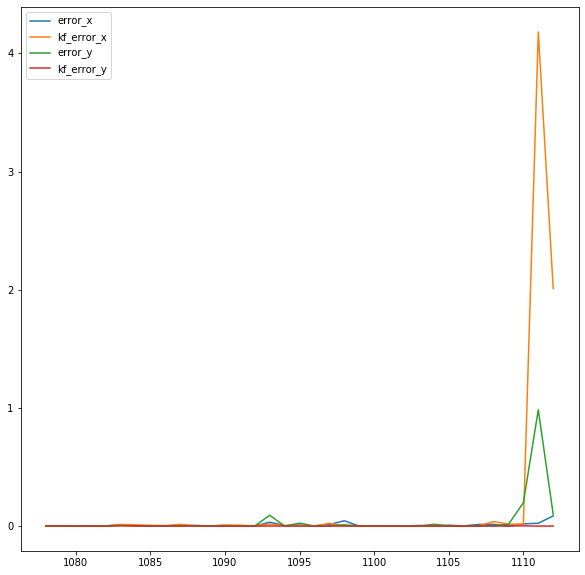

In [68]:
def print_route(route):
    e_x = np.mean(route.loc[:,'error_x'])
    e_kf_x = np.mean(route.loc[:,'kf_error_x'])
    e_y = np.mean(route.loc[:,'error_y'])
    e_kf_y = np.mean(route.loc[:,'kf_error_y'])

    print(f"error_x: {e_x} kf_error_x: {e_kf_x}")
    print(f"error_y: {e_y} kf_error_y: {e_kf_y}")


    plt.plot(route.loc[:,'error_x'], label='error_x')
    plt.plot(route.loc[:,'kf_error_x'], label='kf_error_x')
    plt.plot(route.loc[:,'error_y'], label='error_y')
    plt.plot(route.loc[:,'kf_error_y'], label='kf_error_y')
    plt.legend()
print_route(routes['6_4'])

1.1546787460045709


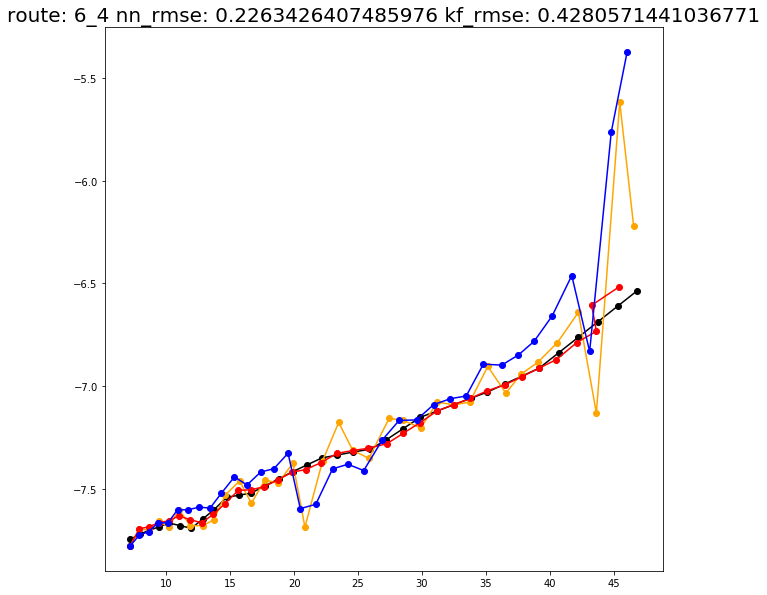

In [71]:
plot_route_df_kf('6_4', routes, eval_info, arrows=False)


1.081229881414709


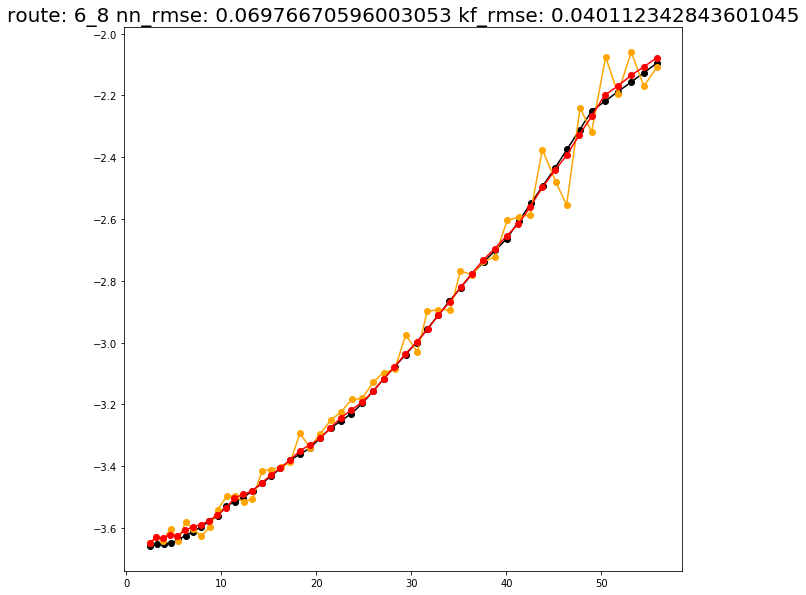

In [74]:
plot_route_df_kf(list(routes.keys())[i], routes, eval_info, arrows=False)
i += 1